In [3]:
import gc
import datetime

import pandas as pd
import numpy as np

from copy import deepcopy
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
from keras import backend as K

import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from IPython.display import clear_output

from libs.pconv_model import PConvUnet
from libs.util import random_mask

%load_ext autoreload
%autoreload 2
plt.ioff()

# SETTINGS
TRAIN_DIR = r"D:/workspace/PConv-Keras/data/food_images_set/train"
TEST_DIR = r"D:/workspace/PConv-Keras/data/food_images_set/validation"
VAL_DIR = r"D:/workspace/PConv-Keras/data/food_images_set/validation"


BATCH_SIZE = 4

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
class DataGenerator(ImageDataGenerator):
    def flow_from_directory(self, directory, *args, **kwargs):
        generator = super().flow_from_directory(directory, class_mode=None, *args, **kwargs)
        while True:
            # Get augmented image samples
            ori = next(generator)

            # Get masks for each image sample
            mask = np.stack([random_mask(ori.shape[1], ori.shape[2]) for _ in range(ori.shape[0])], axis=0)

            # Apply masks to all image sample
            masked = deepcopy(ori)
            masked[mask == 0] = 1

            # Yield ([ori, masl],  ori) training batches
            # print(masked.shape, ori.shape)
            gc.collect()
            yield [masked, mask], ori

# Create testing generator
test_datagen = DataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=(256, 256), batch_size=BATCH_SIZE, seed=1
)

model = PConvUnet(weight_filepath='D:/workspace/PConv-Keras/data/model/')
model.load(r"D:/workspace/PConv-Keras/data/model/40_weights_2018-08-19-02-59-38.h5")

n = 0
for (masked, mask), ori in tqdm(test_generator):
    
    # Run predictions for this batch of images
    pred_img = model.predict([masked, mask])
    pred_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    
    # Clear current output and display test images
    for i in range(len(ori)):
        _, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(masked[i,:,:,:])
        axes[1].imshow(pred_img[i,:,:,:] * 1.)
        axes[0].set_title('Masked Image')
        axes[1].set_title('Predicted Image')
        axes[0].xaxis.set_major_formatter(NullFormatter())
        axes[0].yaxis.set_major_formatter(NullFormatter())
        axes[1].xaxis.set_major_formatter(NullFormatter())
        axes[1].yaxis.set_major_formatter(NullFormatter())
                
        plt.savefig(r'D:/workspace/PConv-Keras/data/test/img_{}_{}.png'.format(i, pred_time))
        plt.close()
        n += 1
        
    # Only create predictions for about 100 images
    if n > 100:
        break


0it [00:00, ?it/s]

Found 104 images belonging to 1 classes.



1it [00:02,  2.19s/it]
2it [00:03,  1.63s/it]
3it [00:04,  1.46s/it]
4it [00:05,  1.39s/it]
5it [00:06,  1.34s/it]
6it [00:07,  1.30s/it]
7it [00:09,  1.31s/it]
8it [00:10,  1.29s/it]
9it [00:11,  1.28s/it]
10it [00:12,  1.26s/it]
11it [00:13,  1.24s/it]
12it [00:14,  1.24s/it]
13it [00:16,  1.23s/it]
14it [00:17,  1.23s/it]
15it [00:18,  1.23s/it]
16it [00:19,  1.22s/it]
17it [00:20,  1.21s/it]
18it [00:21,  1.22s/it]
19it [00:23,  1.24s/it]
20it [00:24,  1.24s/it]
21it [00:25,  1.23s/it]
22it [00:26,  1.22s/it]
23it [00:28,  1.23s/it]
24it [00:29,  1.24s/it]
25it [00:30,  1.24s/it]

In [7]:
masked_img_path="D:/workspace/PConv-Keras/data/food_images/q_1.bmp"

import skimage.io as ski_io
import skimage.color as ski_color
import skimage.morphology as ski_morph

masked = ski_io.imread(masked_img_path)
to_filling = (masked[:, :, 1] > 245) & (masked[:, :, 0] < 10) & (masked[:, :, 2] < 10)
mask_roi= np.zeros((256, 256, 3), np.uint8)
mask_roi[to_filling] = 1

mask = 1.-mask_roi

erosion_size = 11
erosion_type = 0
val_type = cv2.MORPH_ELLIPSE
element = cv2.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
erosion_mask = cv2.erode(mask, element)

masked_tmp_list = []
masked_tmp_list.append(masked)
masked_na = np.array(masked_tmp_list)

mask_tmp_list = []
mask_tmp_list.append(erosion_mask)
mask_na = np.array(mask_tmp_list)

model = PConvUnet(weight_filepath='D:/workspace/PConv-Keras/data/model/')
model.load(r"D:/workspace/PConv-Keras/data/model/40_weights_2018-08-19-02-59-38.h5")

pred_img_set = model.predict([masked_na, mask_na])

pred_img = 255.*pred_img_set[0,:,:,:]

gen_image = masked.copy()
gen_image[to_filling] = pred_img[to_filling]

   

_, axes = plt.subplots(1, 3, figsize=(20, 5))
axes[0].imshow(masked[:,:,:])
axes[1].imshow(mask[:,:,:])
#axes[2].imshow(pred_img[:,:,:])
#axes[2].imshow(erosion_mask[:,:,:])
axes[2].imshow(gen_image[:,:,:])
axes[0].set_title('Masked Image')
axes[1].set_title('Mask Image')
axes[2].set_title('Predicted Image')

Text(0.5,1,'Predicted Image')

Model loaded.
Start of iteration 1
Current loss value: 815512960.0
Iteration 1 completed in 88s
Start of iteration 2
Current loss value: 532672300.0
Iteration 2 completed in 105s
Start of iteration 3
Current loss value: 429321800.0
Iteration 3 completed in 117s
Start of iteration 4
Current loss value: 379923230.0
Iteration 4 completed in 142s


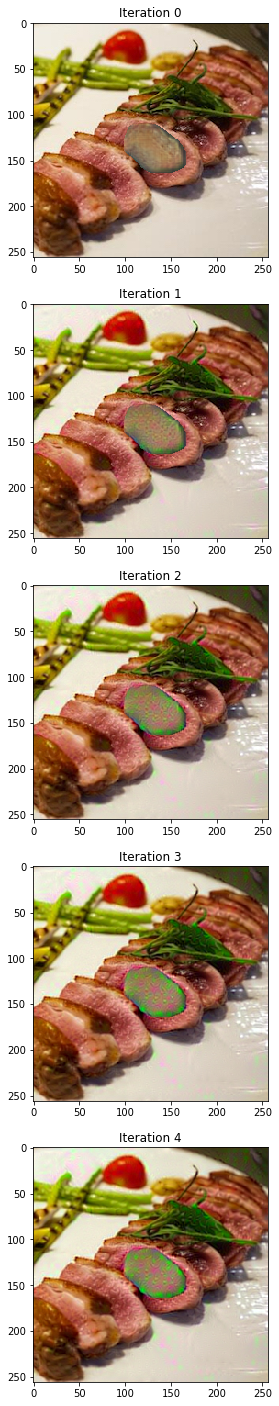